In [17]:
import pandas as pd
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df.sort_values(by="pchembl_value",ascending=False)
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
677,Cc1ccc(CN2C3CCC2CC(Oc2cccc(C(N)=O)c2)C3)cc1,9.85,350.462,3.66832,0.895063
1049,NC(=O)c1cccc(OC2CC3CCC(C2)N3CCCc2ccccc2)c1,9.60,364.489,3.79250,0.813097
1050,NC(=O)c1cccc(OC2CC3CCC(C2)N3CCc2ccccc2)c1,9.42,350.462,3.40240,0.868594
1186,O=C1COc2ccc(CNC34CCC(CCc5ccnc6cc(C(F)(F)F)cnc5...,9.41,513.520,4.17870,0.510428
1056,NC(=O)c1cccc(OC2CC3CCC(C2)N3Cc2cccs2)c1,9.37,342.464,3.42140,0.905668
...,...,...,...,...,...
77,CC(C)OCC(Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)N=c1cc...,4.10,471.880,2.63100,0.439534
1105,O=C(N=c1cccc[nH]1)C(CN1CC(O)C1)Oc1ncnc2c1cnn2-...,4.10,483.891,1.48750,0.425816
187,CCN=c1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(C)C...,4.10,425.470,4.27340,0.702476
338,CNC(=O)c1c[nH]c(=N)c(OC2CN(C(=O)Cc3ccc(OC(F)(F...,4.10,474.386,2.21997,0.558422


In [18]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [19]:
smiles = df['Standardized_SMILES'].values

In [20]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [21]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("pchembl_sorted_fcv_results_MLP_training batches.csv", index=False)
    test_df.to_csv("pchembl_sorted_fcv_results_MLP_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.02534984649841136, pvalue=0.7781270016140129)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.003864840454268558, pvalue=0.9657409747395889)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.18085146301416855, pvalue=0.04270706481176624)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.0580563245063929, pvalue=0.518453702676305)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.12898930449086685, pvalue=0.15001112147415152)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.15899734561009435, pvalue=0.07535722061593404)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.044458034630178896, pvalue=0.621086427041296)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.0007750286308706306, pvalue=0.9931279270362219)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.043098929037654096, pvalue=0.6290602773463423)


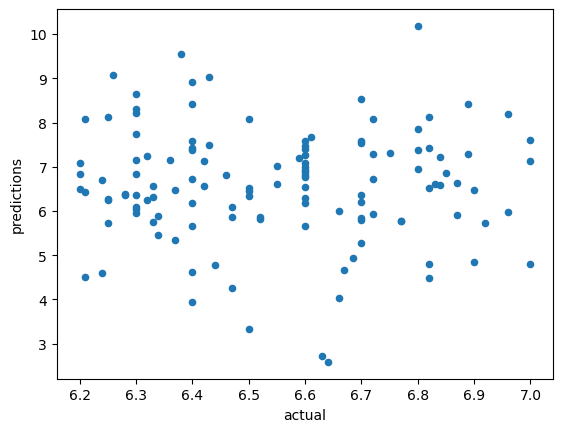

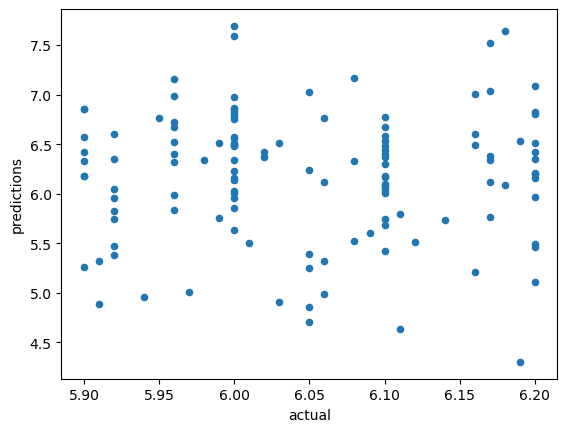

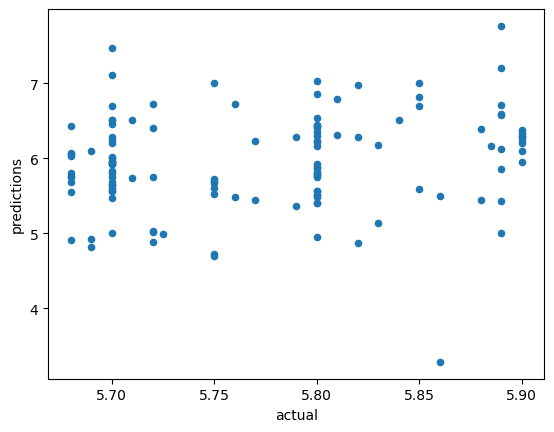

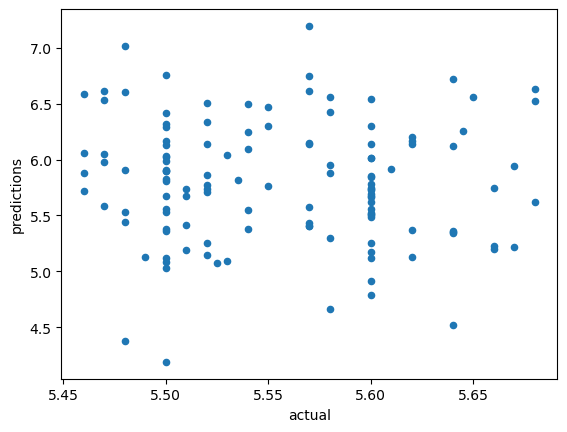

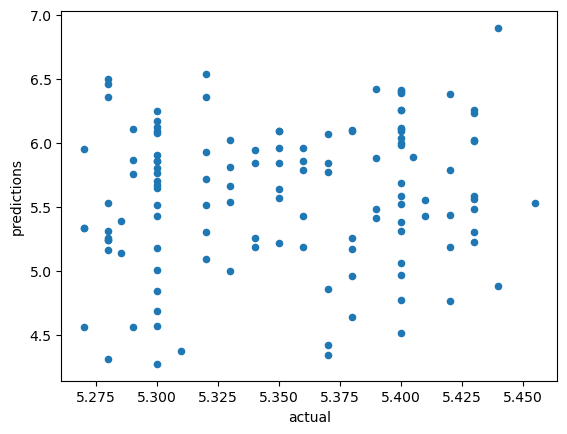

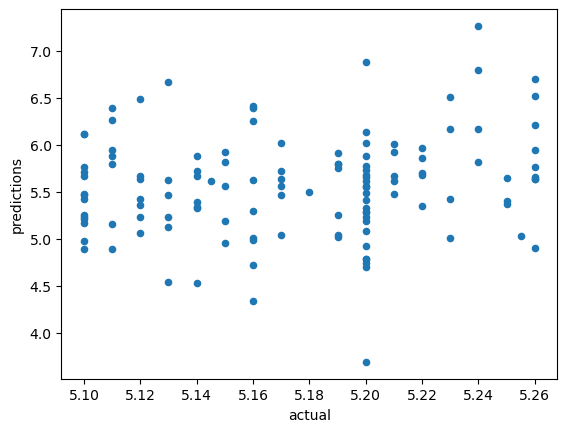

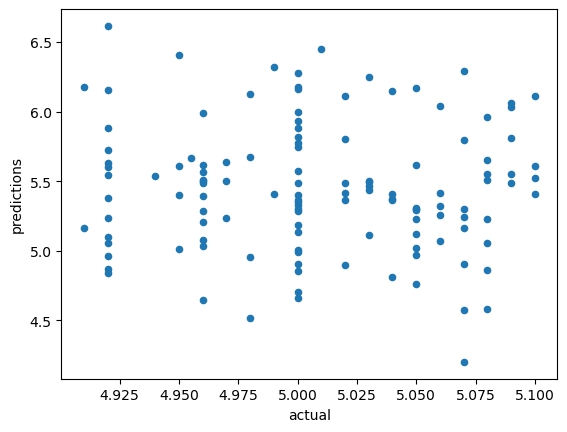

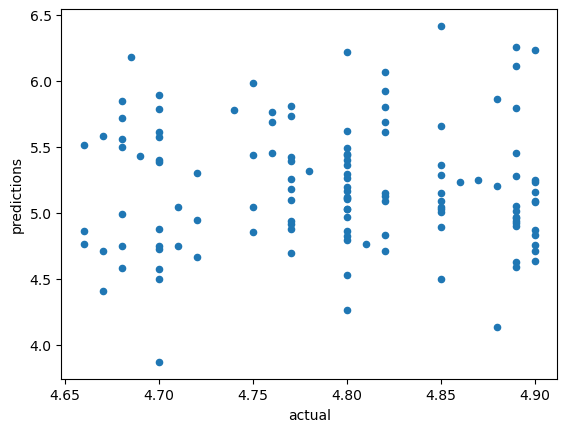

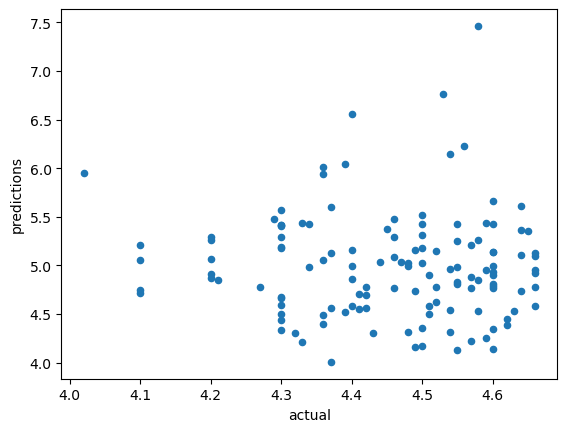

In [22]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [23]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(18, 3)
(35, 3)
(69, 3)
(91, 3)


In [24]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(16, 3)
(10, 3)
(15, 3)
(18, 3)
(29, 3)
(3, 3)
(0, 3)
(0, 3)
(0, 3)


In [25]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(52, 3)
(91, 3)
(57, 3)
(37, 3)


In [26]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(110, 3)
(116, 3)
(111, 3)
(108, 3)
(97, 3)
(28, 3)
(0, 3)
(0, 3)
(0, 3)


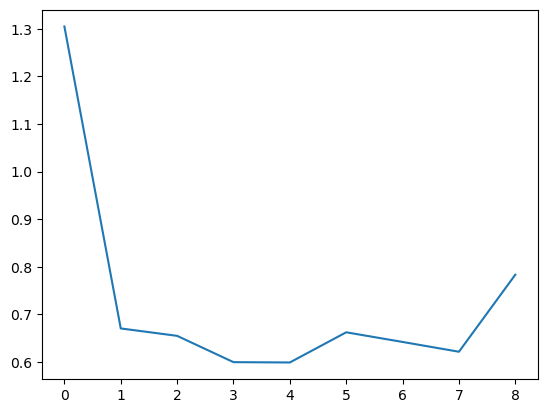

[1.3050970953245977, 0.6705626658096868, 0.6549981647991782, 0.5997156538325011, 0.5990310195505907, 0.6624456575215754, 0.6421653322223569, 0.6215934594895112, 0.7834843081024621]


In [27]:
plt.plot(rmse)
plt.show()
print(rmse)

In [28]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

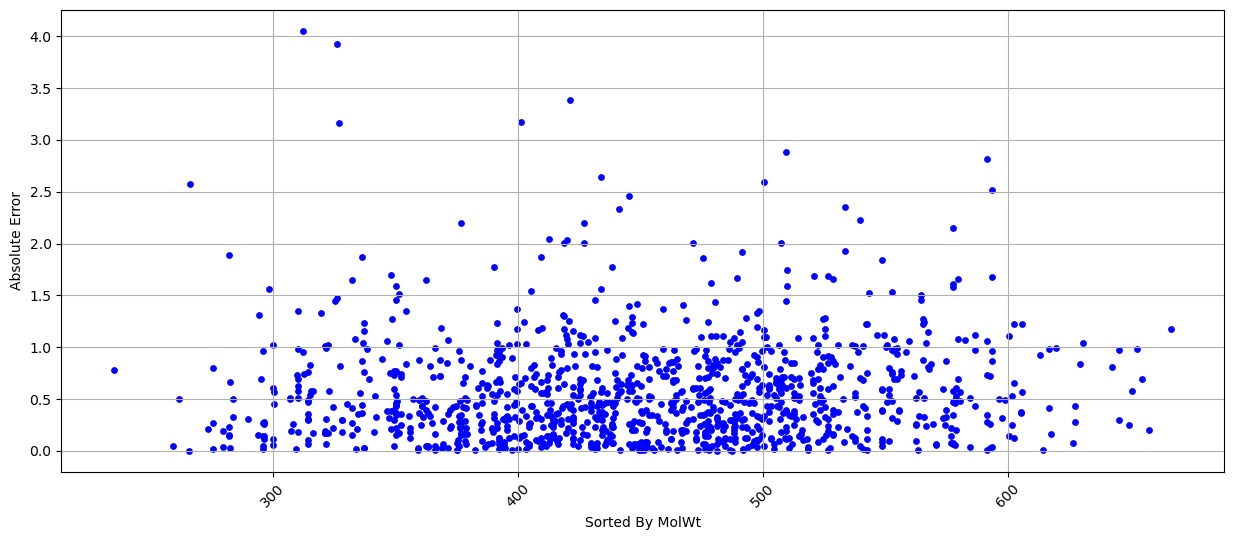

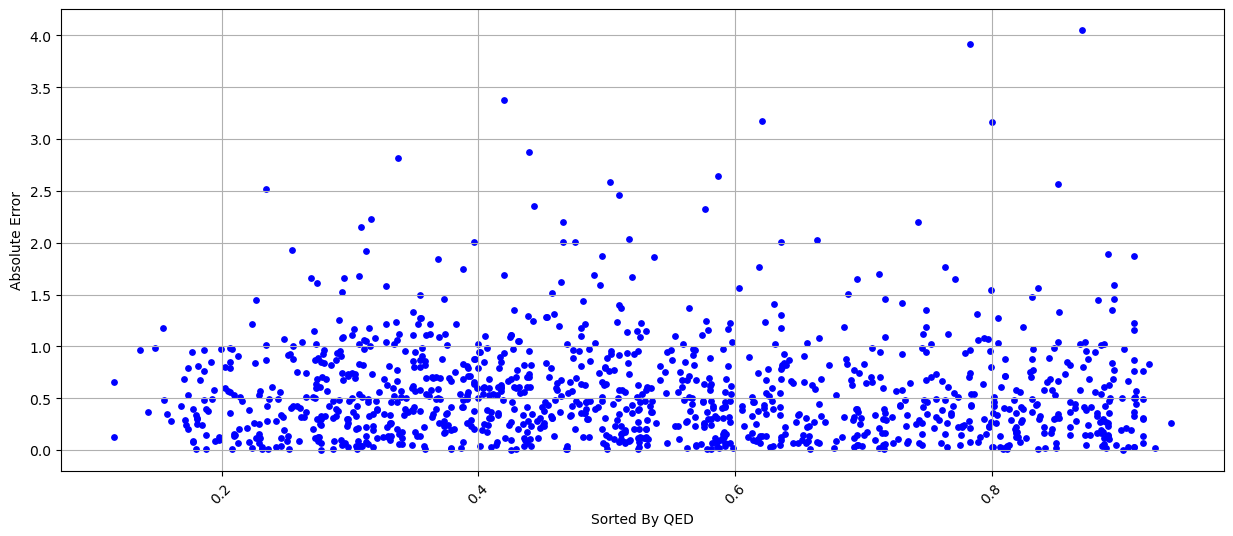

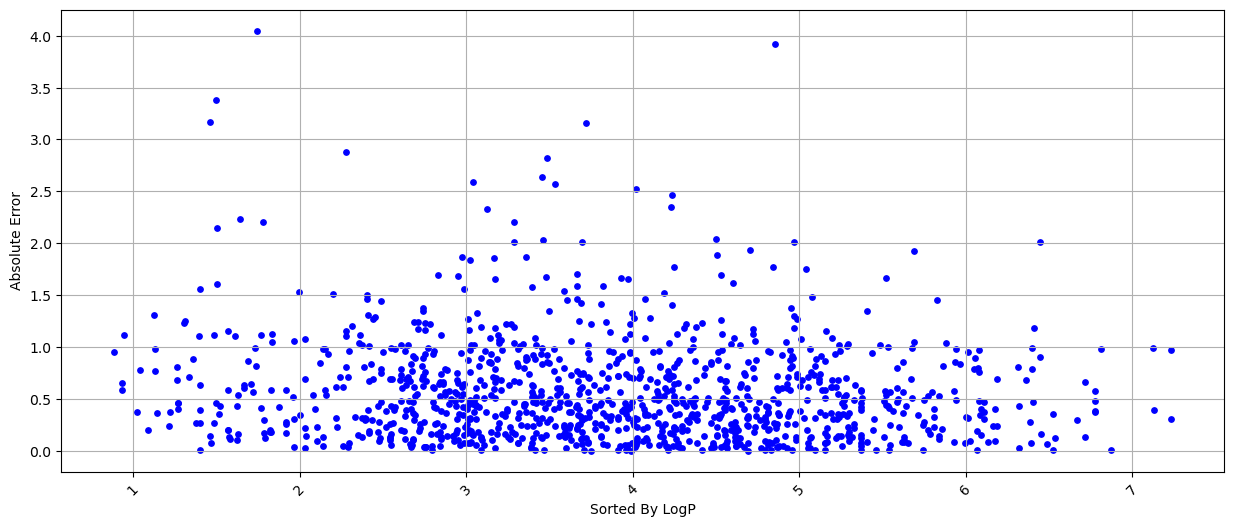

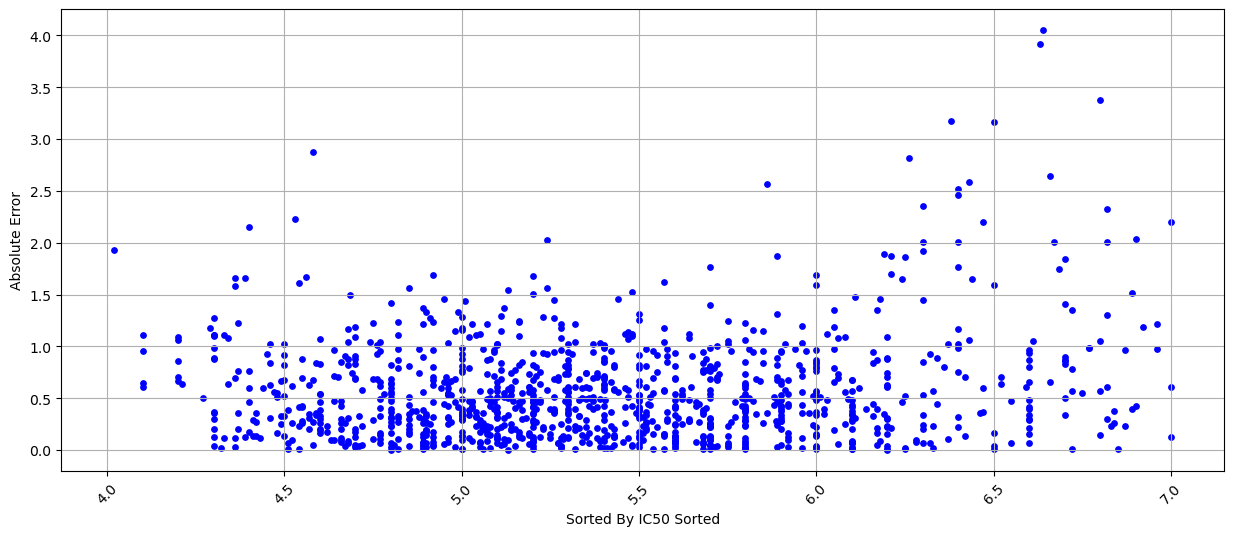

In [29]:
plot_graphs(df, results_df)

In [30]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
677,Cc1ccc(CN2C3CCC2CC(Oc2cccc(C(N)=O)c2)C3)cc1,9.85,350.462,3.66832,0.895063,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1049,NC(=O)c1cccc(OC2CC3CCC(C2)N3CCCc2ccccc2)c1,9.60,364.489,3.79250,0.813097,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1050,NC(=O)c1cccc(OC2CC3CCC(C2)N3CCc2ccccc2)c1,9.42,350.462,3.40240,0.868594,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1186,O=C1COc2ccc(CNC34CCC(CCc5ccnc6cc(C(F)(F)F)cnc5...,9.41,513.520,4.17870,0.510428,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1056,NC(=O)c1cccc(OC2CC3CCC(C2)N3Cc2cccs2)c1,9.37,342.464,3.42140,0.905668,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
77,CC(C)OCC(Oc1ncnc2c1cnn2-c1ncccc1Cl)C(=O)N=c1cc...,4.10,471.880,2.63100,0.439534,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1105,O=C(N=c1cccc[nH]1)C(CN1CC(O)C1)Oc1ncnc2c1cnn2-...,4.10,483.891,1.48750,0.425816,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
187,CCN=c1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(C)C...,4.10,425.470,4.27340,0.702476,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
338,CNC(=O)c1c[nH]c(=N)c(OC2CN(C(=O)Cc3ccc(OC(F)(F...,4.10,474.386,2.21997,0.558422,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("pchembl_sorted_fcv_results_MLP_training batches_druglike.csv", index=False)
    test_df.to_csv("pchembl_sorted_fcv_results_MLP_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,

    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.06038603697316844, pvalue=0.5017813785119138)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.09653963541178412, pvalue=0.2822096295115401)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.08777759062958418, pvalue=0.3283863168055494)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.057115219037413546, pvalue=0.525267918663284)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.1464628391280907, pvalue=0.10173622505161851)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.20448605080986132, pvalue=0.021630183176290764)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.07401168500386376, pvalue=0.41014993842466785)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=0.02162535404163841, pvalue=0.8100567152461949)


C:\Users\udits\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


PearsonRResult(statistic=-0.04587784029416793, pvalue=0.6099717136294899)


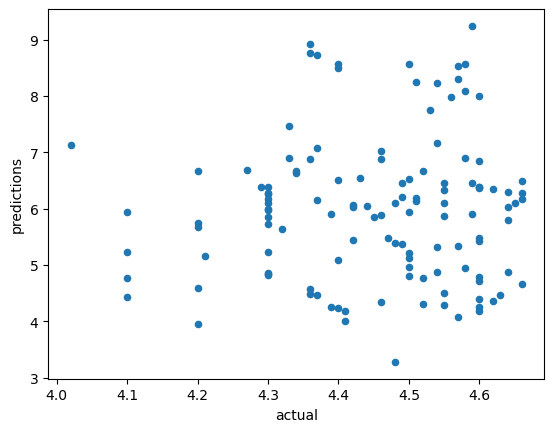

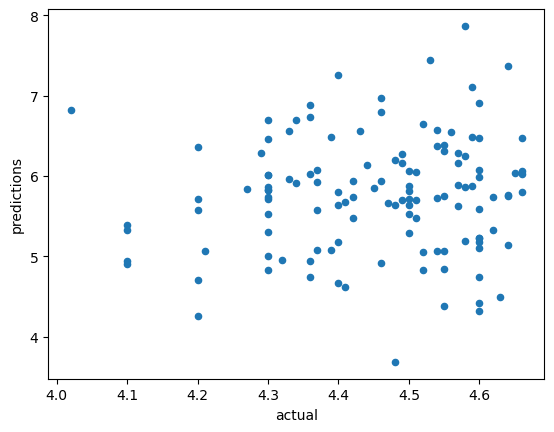

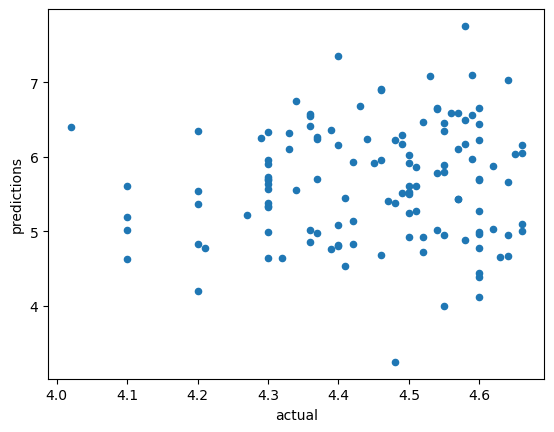

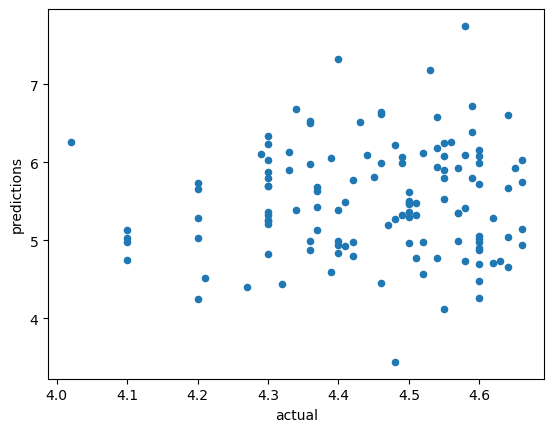

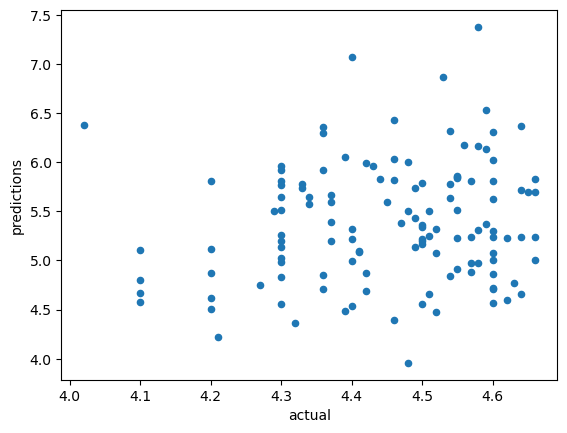

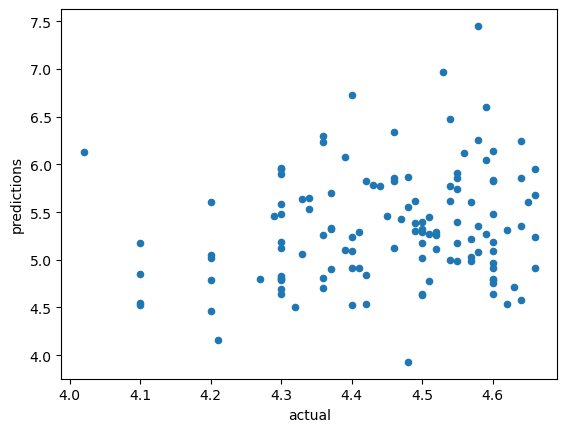

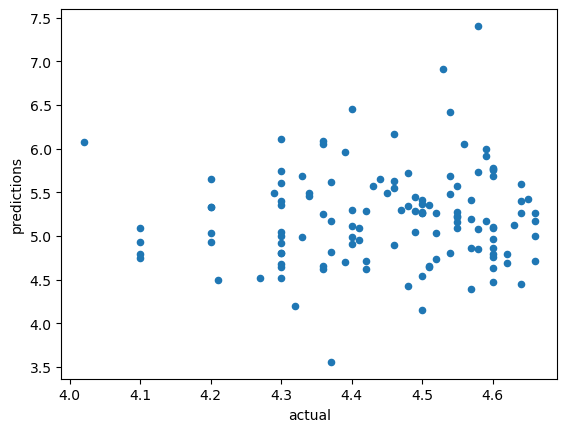

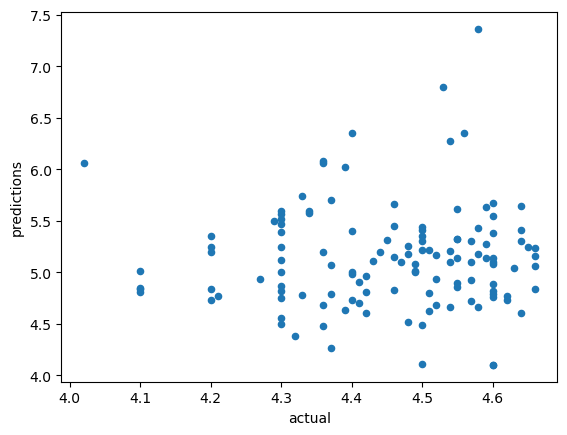

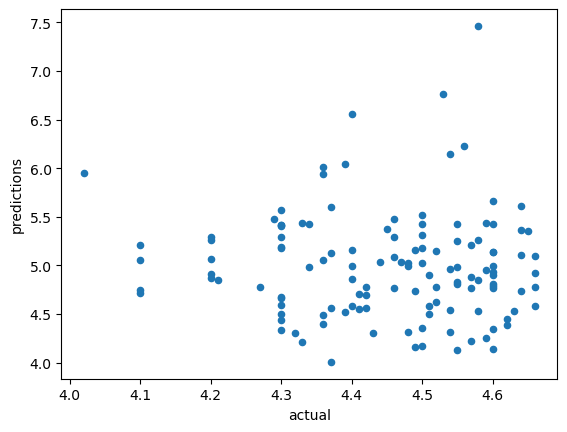

In [32]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [33]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(37, 3)
(31, 3)
(40, 3)
(45, 3)
(48, 3)
(56, 3)
(64, 3)
(77, 3)
(89, 3)


In [34]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [35]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [36]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(89, 3)
(95, 3)
(86, 3)
(81, 3)
(78, 3)
(70, 3)
(62, 3)
(49, 3)
(37, 3)


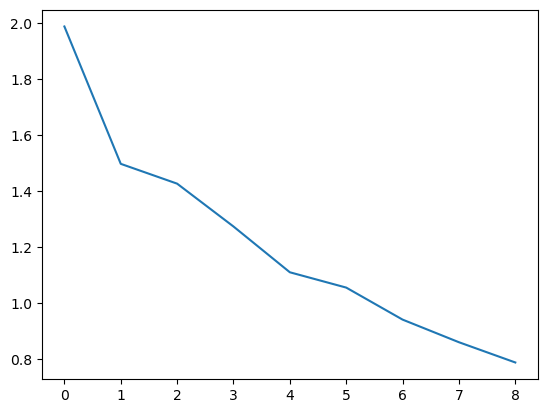

[1.9874996675956087, 1.4971984206531912, 1.426463900044394, 1.2735186340114493, 1.110128585167861, 1.055458878434759, 0.9411663159348631, 0.8604079752346807, 0.7881461968792948]


In [37]:
plt.plot(rmse)
plt.show()
print(rmse)